In [24]:
# Remember to adjust your student ID in meta.xml
import numpy as np
import pickle
import random
import gym
from simple_custom_taxi_env import SimpleTaxiEnv
from tqdm import tqdm
import globals

In [ ]:
# def table_q_learning(episode = 5000, alpha = 0.1, gamma = 0.99, epsilon_start = 1.0, epsilon_end = 0.1, epsilon_decay = 0.999):
#     q_table = {}
#     total_rewards = []

#     for i in tqdm(range(episode)):
#         env = SimpleTaxiEnv(fuel_limit=5000)
#         raw_state, _ = env.reset()
#         total_reward = 0
#         done = False
#         step_count = 0
#         epsilon = epsilon_start
#         taxi_row, taxi_col, _,_,_,_,_,_,_,_,obstacle_north, obstacle_south, obstacle_east, obstacle_west, passenger_look, destination_look = raw_state
#         taxi_pos = (taxi_row, taxi_col)
#         state = ( obstacle_south, obstacle_north, obstacle_east, obstacle_west)

#         saved = False
#         # if (i + 1) % 10000 == 0:
#         #     saved = True
#         #     print(f"=========================={i+1}th episodes Start!==========================")
        
#         while not done:
#             if state not in q_table:
#                 q_table[state] = np.zeros(6)
#             if random.uniform(0, 1) < epsilon:
#                 action = random.choice([0, 1, 2, 3, 4, 5])
#             else:
#                 action = np.argmax(q_table[state])
#             next_raw_state, reward, done, _ = env.step(action)

#             if saved:
#                 env.render_env(taxi_pos, action = action, step = step_count)

#             taxi_row, taxi_col, _,_,_,_,_,_,_,_,obstacle_north, obstacle_south, obstacle_east, obstacle_west, passenger_look, destination_look = next_raw_state
#             taxi_pos = (taxi_row, taxi_col)
#             next_state = ( obstacle_south, obstacle_north, obstacle_east, obstacle_west)
#             if next_state not in q_table:
#                 q_table[next_state] = np.zeros(6)
#             q_table[state][action] = q_table[state][action] + alpha*(reward + gamma*np.max(q_table[next_state]) - q_table[state][action])
#             state = next_state
#             total_reward += reward
#             step_count += 1
#             if epsilon > epsilon_end:
#                 epsilon *= epsilon_decay
#             # if step_count > 500:
#             #     break

#         total_rewards.append(total_reward)
#         if saved:
#             print(f"Episode: {i + 1}/{episode}, Total Reward: {total_reward}, Steps: {step_count}, Epsilon: {epsilon}")

#     return q_table, total_rewards

# def save_q_table(q_table):
#     with open('q_table.pkl', 'wb') as f:
#         pickle.dump(q_table, f)


In [60]:
def find_nearest_station(taxi_pos, station):
    distance = np.inf
    for (x,y) in station:
        temp_distance = abs(taxi_pos[0] - x) + abs(taxi_pos[1] - y)
        if temp_distance < distance:
            distance = temp_distance
            goal = (x, y)
    return goal

In [ ]:
def table_q_learning(episode=5000, alpha=0.1, gamma=0.99, 
                     epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.999):
    q_table = {}
    total_rewards = []
    epsilon = epsilon_start
    total_steps = []

    for i in tqdm(range(episode)):
        # Initialize environment; ensure SimpleTaxiEnv is defined or imported.
        env = SimpleTaxiEnv(fuel_limit=1 if i < 1000 else 1000)
        raw_state, _ = env.reset()
        total_reward = 0
        done = False
        step_count = 0

        taxi_row, taxi_col, R_x, R_y, G_x, G_y, Y_x, Y_y, B_x, B_y, \
        obstacle_north, obstacle_south, obstacle_east, obstacle_west, \
        passenger_look, destination_look = raw_state

        station = [(R_x, R_y), (G_x, G_y), (Y_x, Y_y), (B_x, B_y)]
        globals.possible_passenger = set(station)
        globals.possible_destination = set(station)
        globals.has_passenger = False

        taxi_pos = (taxi_row, taxi_col)
        # Choose initial goal based on nearest station.
        goal = find_nearest_station(taxi_pos, list(station))
        globals.goal = goal
        relative_goal_pos = (goal[0] - taxi_row, goal[1] - taxi_col)
        state = (obstacle_south, obstacle_north, obstacle_east, obstacle_west, 
                 relative_goal_pos[0], relative_goal_pos[1])

        while not done:
            if state not in q_table:
                q_table[state] = np.zeros(6)
            # Choose an action using an epsilon-greedy strategy.
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(6))
            else:
                action = np.argmax(q_table[state])
            
            next_raw_state, reward, done, _ = env.step(action)
            shaped_reward = reward
            if done:
                break
            step_count += 1

            taxi_row, taxi_col, R_x, R_y, G_x, G_y, Y_x, Y_y, B_x, B_y, obstacle_north, obstacle_south, obstacle_east, obstacle_west, passenger_look, destination_look = next_raw_state
            taxi_pos = (taxi_row, taxi_col)

            # Update adjacent cells and possible passenger/destination sets.
            adjacent = {(taxi_row + 1, taxi_col), (taxi_row - 1, taxi_col), 
                        (taxi_row, taxi_col + 1), (taxi_row, taxi_col - 1), 
                        (taxi_row, taxi_col)}
            if passenger_look:
                globals.possible_passenger.intersection_update(adjacent)
            else:
                globals.possible_passenger.difference_update(adjacent)
            if destination_look:
                globals.possible_destination.intersection_update(adjacent)
            else:
                globals.possible_destination.difference_update(adjacent)

            # Update goal using logic similar to get_action.
            if not globals.has_passenger:
                if len(globals.possible_passenger) == 1:
                    if taxi_pos in globals.possible_passenger and action == 4:
                        globals.has_passenger = True
                        globals.possible_passenger = set()
                        goal = list(globals.possible_destination)[0]
                        globals.goal = goal
                        shaped_reward += 100
                    else:
                        goal = list(globals.possible_passenger)[0]
                        globals.goal = goal
                else:
                    if globals.goal in globals.possible_passenger:
                        goal = globals.goal
                    else:
                        goal = find_nearest_station(taxi_pos, list(globals.possible_passenger))
                        globals.goal = goal
            else:
                if action == 5:
                    if len(globals.possible_destination) == 1 and taxi_pos in globals.possible_destination:
                        shaped_reward += 100
                    else:
                        globals.has_passenger = False
                        globals.possible_passenger = {taxi_pos}
                        goal = taxi_pos
                        globals.goal = goal
                        shaped_reward -= 120
                else:
                    if globals.goal in globals.possible_destination:
                        goal = globals.goal
                    else:
                        goal = find_nearest_station(taxi_pos, list(globals.possible_destination))
                        globals.goal = goal

            relative_goal_pos = (goal[0] - taxi_row, goal[1] - taxi_col)
            next_state = (obstacle_south, obstacle_north, obstacle_east, obstacle_west, 
                          relative_goal_pos[0], relative_goal_pos[1])
            
            if next_state not in q_table:
                q_table[next_state] = np.zeros(6)

            # Reward Shaping
            shaped_reward -= 1 * ( abs(relative_goal_pos[0]) + abs(relative_goal_pos[1]) )
            total_reward += shaped_reward

            # Q-learning update using the next state's maximum Q-value.
            q_table[state][action] = q_table[state][action] + alpha * (
                shaped_reward + gamma * np.max(q_table[next_state]) - q_table[state][action])
            state = next_state

        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        total_rewards.append(total_reward)
        total_steps.append(step_count)
        if (i + 1) % 10000 == 0:
            print(f"Episode: {i + 1}/{episode}, Total Reward: {total_reward}, "
                  f"Steps: {step_count}, Epsilon: {epsilon}")

    return q_table, total_rewards

def save_q_table(q_table):
    with open('q_table.pkl', 'wb') as f:
        pickle.dump(q_table, f)


In [134]:
def table_q_learning(
    episode=5000, alpha=0.1, gamma=0.99,
    epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.999
):
    q_table = {}
    total_rewards = []
    total_steps = []
    epsilon = epsilon_start

    for i in tqdm(range(episode)):
        # Initialize environment
        fuel_limit = 1 if i < 1000 else 1000
        env = SimpleTaxiEnv(fuel_limit=fuel_limit)
        raw_state, _ = env.reset()
        total_reward = 0
        done = False
        step_count = 0

        saved = False
        if (i + 1) % 10000 == 0:
            saved = True
            print(f"=========================={i+1}th episodes Start!==========================")

        # Unpack environment state
        (
            taxi_row, taxi_col, R_x, R_y, G_x, G_y, Y_x, Y_y, B_x, B_y,
            obstacle_north, obstacle_south, obstacle_east, obstacle_west,
            passenger_look, destination_look
        ) = raw_state

        # Setup global variables
        station = [(R_x, R_y), (G_x, G_y), (Y_x, Y_y), (B_x, B_y)]
        globals.possible_passenger = set(station)
        globals.possible_destination = set(station)
        globals.has_passenger = False

        taxi_pos = (taxi_row, taxi_col)
        goal = find_nearest_station(taxi_pos, list(station))
        globals.goal = goal

        relative_goal_pos = (goal[0] - taxi_row, goal[1] - taxi_col)
        state = (
            obstacle_south, obstacle_north, obstacle_east, obstacle_west,
            relative_goal_pos[0], relative_goal_pos[1]
        )

        # Q-learning loop
        while not done:
            # Initialize Q-values for unseen state
            if state not in q_table:
                q_table[state] = np.zeros(6)

            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(6))
            else:
                action = np.argmax(q_table[state])

            # Take action in environment
            next_raw_state, reward, done, _ = env.step(action)
            shaped_reward = reward

            if done:
                break

            step_count += 1

            if saved:
                env.render_env(taxi_pos, action = action, step = step_count)

            # Unpack next state
            (
                taxi_row, taxi_col, R_x, R_y, G_x, G_y, Y_x, Y_y, B_x, B_y,
                obstacle_north, obstacle_south, obstacle_east, obstacle_west,
                passenger_look, destination_look
            ) = next_raw_state

            taxi_pos = (taxi_row, taxi_col)

            # Update adjacent observations
            adjacent = {
                (taxi_row + 1, taxi_col), (taxi_row - 1, taxi_col),
                (taxi_row, taxi_col + 1), (taxi_row, taxi_col - 1),
                (taxi_row, taxi_col)
            }

            if passenger_look:
                globals.possible_passenger.intersection_update(adjacent)
            else:
                globals.possible_passenger.difference_update(adjacent)

            if destination_look:
                globals.possible_destination.intersection_update(adjacent)
            else:
                globals.possible_destination.difference_update(adjacent)

            # Goal logic
            if not globals.has_passenger:
                if len(globals.possible_passenger) == 1:
                    if taxi_pos in globals.possible_passenger and action == 4:
                        globals.has_passenger = True
                        globals.possible_passenger = set()
                        goal = list(globals.possible_destination)[0]
                        globals.goal = goal
                        shaped_reward += 20
                    else:
                        goal = list(globals.possible_passenger)[0]
                        globals.goal = goal
                else:
                    if globals.goal in globals.possible_passenger:
                        goal = globals.goal
                    else:
                        goal = find_nearest_station(taxi_pos, list(globals.possible_passenger))
                        globals.goal = goal
            else:
                if action == 5:
                    if len(globals.possible_destination) == 1 and taxi_pos in globals.possible_destination:
                        shaped_reward += 100
                    else:
                        globals.has_passenger = False
                        globals.possible_passenger = {taxi_pos}
                        goal = taxi_pos
                        globals.goal = goal
                        shaped_reward -= 30
                else:
                    if globals.goal in globals.possible_destination:
                        goal = globals.goal
                    else:
                        goal = find_nearest_station(taxi_pos, list(globals.possible_destination))
                        globals.goal = goal

            # Compute next state
            relative_goal_pos = (goal[0] - taxi_row, goal[1] - taxi_col)
            next_state = (
                obstacle_south, obstacle_north, obstacle_east, obstacle_west,
                relative_goal_pos[0], relative_goal_pos[1]
            )

            if next_state not in q_table:
                q_table[next_state] = np.zeros(6)

            # Reward shaping (distance to goal)
            shaped_reward -= 2 * (abs(relative_goal_pos[0]) + abs(relative_goal_pos[1]))
            total_reward += shaped_reward

            if saved:
                print(f"Shaped_Reward: {shaped_reward}, Reward: {reward}")

            # Q-learning update
            q_table[state][action] += alpha * (
                shaped_reward + gamma * np.max(q_table[next_state]) - q_table[state][action]
            )

            state = next_state

        # Epsilon decay
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        total_rewards.append(total_reward)
        total_steps.append(step_count)

        # Optional progress logging
        if (i + 1) % 10000 == 0:
            print(f"Episode: {i + 1}/{episode}, Total Reward: {total_reward}, "
                  f"Steps: {step_count}, Epsilon: {epsilon:.4f}")

    return q_table, total_rewards


def save_q_table(q_table, filename='q_table.pkl'):
    """Save the Q-table to a file using pickle."""
    with open(filename, 'wb') as f:
        pickle.dump(q_table, f)

In [135]:
q_table, total_rewards = table_q_learning(episode = 10000, alpha = 0.1, gamma = 0.99, epsilon_start = 1.0, epsilon_end = 0.1, epsilon_decay = 0.9999)
save_q_table(q_table)

100%|██████████| 10000/10000 [01:08<00:00, 144.95it/s]

==========================10000th episodes Start!==========================

Step: 1
Taxi Position: (6, 0)
Passenger Position: (1, 0) 
Destination: (3, 6)
Fuel Left: None
Last Action: Move South

. P . . . . 🚖 .
. . . . . . . B
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . D . . . .
. G . . . . . .


Shaped_Reward: -7.1, Reward: 4.9

Step: 2
Taxi Position: (6, 1)
Passenger Position: (1, 0) 
Destination: (3, 6)
Fuel Left: None
Last Action: Move East

. P . . . . . .
. . . . . . 🚖 B
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . D . . . .
. G . . . . . .


Shaped_Reward: -9.1, Reward: 4.9

Step: 3
Taxi Position: (7, 1)
Passenger Position: (1, 0) 
Destination: (3, 6)
Fuel Left: None
Last Action: Move West

. P . . . . . .
. . . . . . . 🚖
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . D . . . .
. G . . . . . .


Shaped_Reward: -7.1, Reward: 4.9

Step: 4
Taxi Position: (6, 1)
Passenger Position: (1, 0) 
Destination: (3, 6

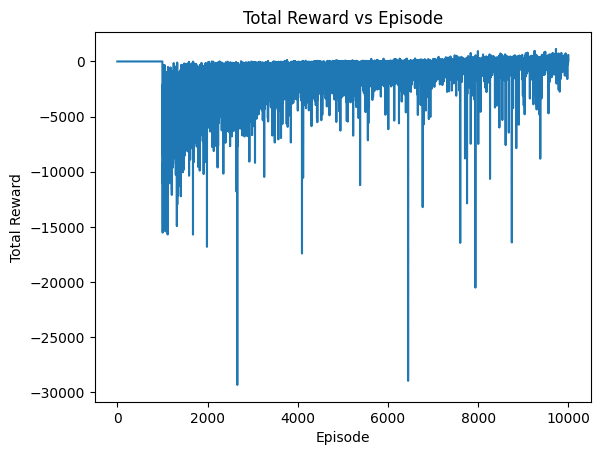

In [136]:
# plot total rewards
import matplotlib.pyplot as plt
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.show()

In [ ]:
def table_q_learning(episode=5000, alpha=0.1, gamma=0.99, 
                     epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.999):
    q_table = {}
    total_rewards = []
    epsilon = epsilon_start

    for i in tqdm(range(episode)):
        # Initialize environment; ensure SimpleTaxiEnv is defined or imported.
        env = SimpleTaxiEnv(fuel_limit=1 if episode < 1000 else 1000)
        raw_state, _ = env.reset()
        total_reward = 0
        done = False
        step_count = 0

        taxi_row, taxi_col, R_x, R_y, G_x, G_y, Y_x, Y_y, B_x, B_y, \
        obstacle_north, obstacle_south, obstacle_east, obstacle_west, \
        passenger_look, destination_look = raw_state

        station = [(R_x, R_y), (G_x, G_y), (Y_x, Y_y), (B_x, B_y)]
        globals.possible_passenger = set(station)
        globals.possible_destination = set(station)
        globals.has_passenger = False

        taxi_pos = (taxi_row, taxi_col)
        # Choose initial goal based on nearest station.
        goal = find_nearest_station(taxi_pos, list(station))
        globals.goal = goal
        relative_goal_pos = (goal[0] - taxi_row, goal[1] - taxi_col)
        state = (obstacle_south, obstacle_north, obstacle_east, obstacle_west, 
                 relative_goal_pos[0], relative_goal_pos[1], globals.has_passenger)

        while not done:
            if state not in q_table:
                q_table[state] = np.zeros(6)
            # Choose an action using an epsilon-greedy strategy.
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(6))
            else:
                action = np.argmax(q_table[state])
            
            next_raw_state, reward, done, _ = env.step(action)
            shaped_reward = reward
            if done:
                break
            step_count += 1

            taxi_row, taxi_col, R_x, R_y, G_x, G_y, Y_x, Y_y, B_x, B_y, obstacle_north, obstacle_south, obstacle_east, obstacle_west, passenger_look, destination_look = next_raw_state
            taxi_pos = (taxi_row, taxi_col)

            # Update adjacent cells and possible passenger/destination sets.
            adjacent = {(taxi_row + 1, taxi_col), (taxi_row - 1, taxi_col), 
                        (taxi_row, taxi_col + 1), (taxi_row, taxi_col - 1), 
                        (taxi_row, taxi_col)}
            if passenger_look:
                globals.possible_passenger.intersection_update(adjacent)
            else:
                globals.possible_passenger.difference_update(adjacent)
            if destination_look:
                globals.possible_destination.intersection_update(adjacent)
            else:
                globals.possible_destination.difference_update(adjacent)

            # Update goal using logic similar to get_action.
            if not globals.has_passenger:
                if len(globals.possible_passenger) == 1:
                    if taxi_pos in globals.possible_passenger and action == 4:
                        globals.has_passenger = True
                        globals.possible_passenger = set()
                        goal = list(globals.possible_destination)[0]
                        globals.goal = goal
                        shaped_reward += 150
                    else:
                        goal = list(globals.possible_passenger)[0]
                        globals.goal = goal
                else:
                    if globals.goal in globals.possible_passenger:
                        goal = globals.goal
                    else:
                        goal = find_nearest_station(taxi_pos, list(globals.possible_passenger))
                        globals.goal = goal
            else:
                if action == 4:
                    shaped_reward -= 150
                if action == 5:
                    if len(globals.possible_destination) == 1 and taxi_pos in globals.possible_destination:
                        shaped_reward += 500
                        globals.has_passenger = False
                        globals.possible_destination = {taxi_pos}
                        goal = taxi_pos
                        globals.goal = goal
                    else:
                        globals.has_passenger = False
                        globals.possible_passenger = {taxi_pos}
                        goal = taxi_pos
                        globals.goal = goal
                        shaped_reward -= 170
                else:
                    if globals.goal in globals.possible_destination:
                        goal = globals.goal
                    else:
                        goal = find_nearest_station(taxi_pos, list(globals.possible_destination))
                        globals.goal = goal

            relative_goal_pos = (goal[0] - taxi_row, goal[1] - taxi_col)
            next_state = (obstacle_south, obstacle_north, obstacle_east, obstacle_west, 
                          relative_goal_pos[0], relative_goal_pos[1])
            
            if next_state not in q_table:
                q_table[next_state] = np.zeros(6)

            # Reward Shaping
            shaped_reward -= 1 * ( abs(relative_goal_pos[0]) + abs(relative_goal_pos[1]) )
            total_reward += shaped_reward

            # Q-learning update using the next state's maximum Q-value.
            q_table[state][action] = q_table[state][action] + alpha * (
                shaped_reward + gamma * np.max(q_table[next_state]) - q_table[state][action])
            state = next_state

            epsilon = max(epsilon_end, epsilon * epsilon_decay)

        total_rewards.append(total_reward)
        if (i + 1) % 10000 == 0:
            print(f"Episode: {i + 1}/{episode}, Total Reward: {total_reward}, "
                  f"Steps: {step_count}, Epsilon: {epsilon}")

    return q_table, total_rewards

def save_q_table(q_table):
    with open('q_table.pkl', 'wb') as f:
        pickle.dump(q_table, f)


{(0, 1, 0, 0, 0, -3): array([359.75656397, 315.00083504, 345.93379972, 396.49665894,
       332.76824939, 342.85730756]), (0, 0, 0, 0, 0, -2): array([400.64992064, 401.34148533, 401.55714753, 368.01197668,
       400.99252013, 398.855994  ]), (0, 0, 1, 0, 1, -2): array([387.87031903, 387.54130325, 392.27704136, 408.14574456,
       390.86662903, 383.58894952]), (0, 0, 0, 0, 1, -1): array([400.88108214, 402.06391476, 405.39819104, 436.60549704,
       407.79751971, 403.64799243]), (0, 1, 0, 0, 2, -2): array([389.89956744, 349.19637719, 337.63180188, 317.81326478,
       339.07656983, 343.37043413]), (0, 0, 0, 1, 2, -1): array([423.23388393, 366.24080864, 374.49533136, 370.39957446,
       372.1886931 , 371.75180394]), (0, 1, 0, 0, -1, 5): array([103.9320341 ,  58.59212247, 267.33145626,  72.10646353,
       106.78234684, 122.03825935]), (0, 0, 0, 0, -1, 4): array([263.39466705, 349.29201923, 375.5956215 , 271.42022242,
       302.16992665, 340.3737292 ]), (0, 0, 0, 0, -2, 4): array([192